# Preparación ambiente

In [10]:
#from google.colab import drive
#drive.mount('/content/drive')

In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Importación dataset

In [12]:
old_data=pd.read_csv("patient.csv")

In [13]:
old_data.columns

Index(['sex', 'hospitalized', 'intubated', 'pneumonia', 'age', 'pregnant',
       'diabetes', 'copd', 'asthma', 'immunosuppression', 'hypertension',
       'other_diseases', 'cardiovascular', 'obesity', 'chronic_kidney_failure',
       'smoker', 'another_case', 'outcome', 'icu', 'dead'],
      dtype='object')

In [14]:
old_data.head()

,sex,hospitalized,intubated,pneumonia,age,pregnant,diabetes,copd,asthma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_kidney_failure,smoker,another_case,outcome,icu,dead
0,1,0,97,0,42,0,0,0,1,0,0,0,0,0,0,0,0,1,97,0
1,1,1,0,0,51,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0
2,1,1,0,0,57,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
3,1,1,0,1,89,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,97,0,55,0,1,0,1,0,1,0,0,1,0,0,0,1,97,0


In [15]:
old_data = old_data.drop(["icu", "intubated", "dead"], axis=1)

In [16]:
print(old_data.nunique())
print(old_data.shape)

sex                         2
hospitalized                2
pneumonia                   2
age                       104
pregnant                    2
diabetes                    2
copd                        2
asthma                      2
immunosuppression           2
hypertension                2
other_diseases              2
cardiovascular              2
obesity                     2
chronic_kidney_failure      2
smoker                      2
another_case                2
outcome                     2
dtype: int64
(82520, 17)


In [17]:
old_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82520 entries, 0 to 82519
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   sex                     82520 non-null  int64
 1   hospitalized            82520 non-null  int64
 2   pneumonia               82520 non-null  int64
 3   age                     82520 non-null  int64
 4   pregnant                82520 non-null  int64
 5   diabetes                82520 non-null  int64
 6   copd                    82520 non-null  int64
 7   asthma                  82520 non-null  int64
 8   immunosuppression       82520 non-null  int64
 9   hypertension            82520 non-null  int64
 10  other_diseases          82520 non-null  int64
 11  cardiovascular          82520 non-null  int64
 12  obesity                 82520 non-null  int64
 13  chronic_kidney_failure  82520 non-null  int64
 14  smoker                  82520 non-null  int64
 15  another_case       

In [18]:
old_data = old_data.assign(agegroup=pd.cut(old_data['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], right=False, labels=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90-99"]))

# Dataset casi completo

## Creación variables X e Y

Eliminamos las columnas death_date, intubated y icu (por su correlación lineal con intubated)

In [19]:
x=old_data.drop(["hospitalized"],axis=1)
y=old_data["hospitalized"]
y=pd.DataFrame(y)
y

,hospitalized
0,0
1,1
2,1
3,1
4,0
...,...
82515,1
82516,0
82517,0
82518,0


In [20]:
x = pd.get_dummies(data=x, columns= x.columns,drop_first = True)

In [21]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)
print ("X_train:" , x_train.shape[0])
print ("y_train:" , y_train.shape[0])
print ("X_test:" , x_test.shape[0])
print ("y_test:" , y_test.shape[0])

X_train: 66016
y_train: 66016
X_test: 16504
y_test: 16504


In [22]:
y_train=pd.DataFrame(y_train)
y_train

,hospitalized
22952,1
14967,0
26181,1
16907,0
21841,1
...,...
21440,1
73349,0
50057,0
5192,0


In [23]:
y_train=y_train.astype('float')
y_test=y_test.astype('float')

## Machine Learning Algorithms

In [25]:
#Naive Bayes
nb=MultinomialNB()
nb.fit(x_train, y_train)
score_nb=nb.score(x_test,y_test)

#KNN
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
score_knn=knn.score(x_test,y_test)

#Score
print ("KNN Acc Score:",score_knn)
print ("NB Score:", score_nb)

KNN Acc Score: 0.8568831798351915
NB Score: 0.8307077072224915


In [26]:
y_pred_nb = nb.predict(x_test)
y_pred_knn = knn.predict(x_test)

In [27]:
print("AS NB:\n", accuracy_score(y_test, y_pred_nb))
print("AS KNN:\n", accuracy_score(y_test, y_pred_knn))

AS NB:
 0.8307077072224915
AS KNN:
 0.8568831798351915


## Confusion_matrix

In [28]:
print("CM NB:\n", confusion_matrix(y_test, y_pred_nb))
print("CM KNN:\n", confusion_matrix(y_test, y_pred_knn))

CM NB:
 [[11000  1338]
 [ 1456  2710]]
CM KNN:
 [[11515   823]
 [ 1539  2627]]


## Recall,Precision and F-1 Score


* Recall    =  TP / (TP + FN)
* Precision = TP / (TP + FP) 
* F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [29]:
print("NB:\n", classification_report(y_test,y_pred_nb))
print("KNN:\n", classification_report(y_test,y_pred_knn))

NB:
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.89     12338
         1.0       0.67      0.65      0.66      4166

    accuracy                           0.83     16504
   macro avg       0.78      0.77      0.77     16504
weighted avg       0.83      0.83      0.83     16504

KNN:
               precision    recall  f1-score   support

         0.0       0.88      0.93      0.91     12338
         1.0       0.76      0.63      0.69      4166

    accuracy                           0.86     16504
   macro avg       0.82      0.78      0.80     16504
weighted avg       0.85      0.86      0.85     16504



In [30]:
print ("F1 Score NB:", f1_score(y_test,y_pred_nb))
print ("F1 Score KNN:", f1_score(y_test,y_pred_knn))

F1 Score NB: 0.6598490382274166
F1 Score KNN: 0.6898634453781513


## roc & auc

In [31]:
#NB
probs_nb=nb.predict_proba(x_test)
preds_nb=probs_nb[:,1]
fpr_nb,tpr_nb, threshold_nb =metrics.roc_curve(y_test, y_pred_nb)
roc_auc_nb=metrics.auc(fpr_nb,tpr_nb)

#KNN
probs_knn=knn.predict_proba(x_test)
preds_knn=probs_knn[:,1]
fpr_knn,tpr_knn, threshold_knn =metrics.roc_curve(y_test, y_pred_knn)
roc_auc_knn=metrics.auc(fpr_knn,tpr_knn)

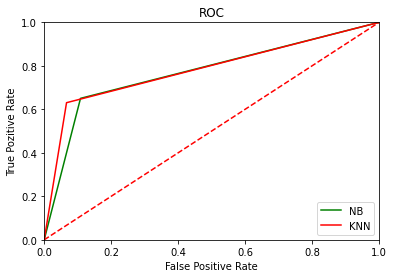

In [32]:
plt.title("ROC")

plt.plot(fpr_nb, tpr_nb, 'g', label="NB" % roc_auc_nb)
plt.plot(fpr_knn, tpr_knn, 'r', label="KNN" % roc_auc_nb)

plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Pozitive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## GridSearch

In [33]:
k_range = list(range(10, 21))
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}


In [34]:
folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)

In [35]:
grid = GridSearchCV(knn, param_grid, cv=folds, scoring='accuracy')

In [ ]:
grid.fit(x_train, y_train)

In [ ]:
pd.DataFrame(grid.cv_results_)

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
y_pred_grid = grid.predict(xd_test)

In [ ]:
confusion = confusion_matrix(y_test, y_pred_grid)

In [ ]:
confusion

In [ ]:
print (classification_report(y_test, y_pred_grid))